In [6]:

import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys

dt = 0.1
tstart = 0
tlim = 200
t = np.arange(tstart, tlim, 1)

ndiv = 1/dt

### keep it always starting at 0
tmoh = np.arange(0, tlim, dt)

N_city = 1

PHU_path = './../../../../PHU_Data/'

Data = np.zeros([365,4])

files = os.listdir(PHU_path)

target_file1 = f'{PHU_path}/30-Toronto.csv'
target_file2 = f'{PHU_path}/34-York.csv'
target_file3 = f'{PHU_path}/04-Durham.csv'
target_file4 = f'{PHU_path}/22-PeelRegion.csv'

Data[:,0] = np.genfromtxt(target_file1, delimiter=',')
Data[:,1] = np.genfromtxt(target_file2, delimiter=',')
Data[:,2] = np.genfromtxt(target_file3, delimiter=',')
Data[:,3] = np.genfromtxt(target_file4, delimiter=',')


population_by_phu = np.genfromtxt(f'{PHU_path}/population_by_phu.csv', delimiter=',')


# Preallocate compartments
S = np.zeros((len(tmoh),N_city))
E = np.zeros((len(tmoh),N_city))
I = np.zeros((len(tmoh),N_city))
R = np.zeros((len(tmoh),N_city))
D = np.zeros((len(tmoh),N_city))
N = np.zeros((len(tmoh),N_city))


# For noisy synthetic model output
I_model = np.zeros((len(t),N_city))
I_synthetic = np.zeros((len(t),N_city))

 
total = np.zeros((N_city))

 ####### CHANGE HERE ######################
total[0] = population_by_phu[29,1]
 #####################################

# Initial Conditions
 ####### CHANGE HERE ######################
E[0,0] = Data[0,0]
I[0,0] = Data[0,0]
 #####################################
R[0,0] = 0
D[0,0] = 0
N[0,0] = total[0]
S[0,0] = N[0,0] - E[0,0] - I[0,0] - R[0,0] - D[0,0]


# Model parameters - Taken from Southern Ontario - COVID MBE paper
gamma_e = 1/15
gamma_i = 1/5
gamma_r = 1/11
gamma_d = 1/750

beta_e = np.zeros((len(tmoh),N_city)) 
beta_i = np.zeros((len(tmoh),N_city))

beta_calibrated = np.zeros((len(tmoh),N_city))


print("initial infected in PHU1",I[0,0])

print("total population in PHU1",total[0])

#### PEEL - 234 , 1451022

#### Toronto - 430 , 2794356

### York - 212, 1173334

### Durham - 94   - 696992


initial infected in PHU1 430.0
total population in PHU1 2794356.0


In [8]:

# True data

sample_path = '/Users/sudhipv/documents/sequential_calibration/singlePHU_compare/without_rho/mcmc'

true_path  =  '/Users/sudhipv/documents/sequential_calibration/singlePHU_compare/without_rho/mcmc/toronto_synthetic_true_mult.csv'

I_truth = np.genfromtxt(true_path, delimiter=' ')

I_mean = np.zeros((len(tmoh),N_city))

# samples = np.loadtxt('/Users/sudhipv/documents/plos_coupledode/codes/tmcmc/16param/muVec.dat')

samples = np.loadtxt(f'{sample_path}/muVec.dat')

print(samples.shape)

Nsamples = len(samples[0,:])

I_pdf = np.zeros((40,Nsamples))




for ns in range(Nsamples):


### Toronto
    a0 = samples[0,ns]
    a1 = samples[1,ns]
    t1 =  20
    a2 = samples[2,ns]
    t2 =  35
    a3 =  samples[3,ns]
    t3 = 60
    a4 =  samples[4,ns]
    t4 = 80
    a5 =  samples[5,ns]
    t5 =  140



    beta_i[:,0] = a0  + a1/(1 + np.exp((t1-tmoh))) +  a2/(1 + np.exp((t2-tmoh)))  + a3/(1 + np.exp((t3-tmoh)))  + a4/(1 + np.exp((t4-tmoh)))  + a5/(1 + np.exp((t5-tmoh)))  
                #  + a6/(1 + np.exp((t6-tmoh))) + a7/(1 + np.exp((t7-tmoh))) 
    # + a8/(1 + np.exp((t8-tmoh)))

    beta_e[:,0] = beta_i[:,0]

    idxmoh = 0

    #### With mobility tensor   

    FoI = np.zeros((len(tmoh),1))
        
    for kk in range(1,len(tmoh)):

        FoI[kk,0] = beta_e[kk-1,0] * (E[kk-1,0] + I[kk-1,0]) / N[kk-1,0]

        S[kk,0] = S[kk-1,0] + dt*(- FoI[kk,0] * S[kk-1,0])
        E[kk,0] = E[kk-1,0] + dt*(FoI[kk,0]*S[kk-1,0] - (gamma_i + gamma_e)*E[kk-1,0])
        
        I[kk,0] = I[kk-1,0] + dt*(gamma_i*E[kk-1,0] - (gamma_r + gamma_d)*I[kk-1,0])
        R[kk,0] = R[kk-1,0] + dt*(gamma_e*E[kk-1,0] + gamma_r*I[kk-1,0])
        D[kk,0] = D[kk-1,0] + dt*(gamma_d*I[kk-1,0])
        N[kk,0] = S[kk,0] +  E[kk,0] + I[kk,0] + R[kk,0]

 # Compute mean predictions
        I_mean[kk,0] = I_mean[kk,0] + I[kk,0]

        if( kk%ndiv == 0):
            idxmoh = int(kk/ndiv)

            if(idxmoh >= 160):

                I_pdf[idxmoh-160,ns] = I[kk,0]



I_mean = I_mean/Nsamples


(6, 2000)


(6, 2000)


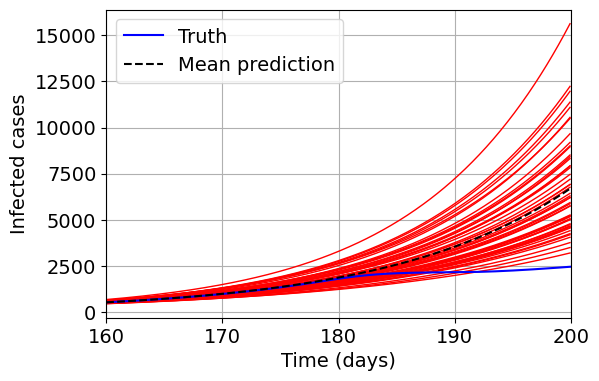

In [18]:

mpl.rcParams.update({'font.size':14})
fig1, ax1 = plt.subplots(figsize=(6, 4))
ax1.set_xlim([160,200])
# ax1.set_xticks(np.arange(160, 200), 10.0)
# ax1.set_yticks(np.arange(0, 5000, 50.0))
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Infected cases') 


pred_low = int(160*ndiv)

pred_high = int(200*ndiv)


print(samples.shape)

Nsamples = 50

for ns in range(Nsamples):


##### For Toronto
    a0 = samples[0,ns]
    a1 = samples[1,ns]
    t1 =  20
    a2 = samples[2,ns]
    t2 =  35
    a3 =  samples[3,ns]
    t3 = 60
    a4 =  samples[4,ns]
    t4 = 80
    a5 =  samples[5,ns]
    t5 =  140


    beta_i[:,0] = a0  + a1/(1 + np.exp((t1-tmoh))) +  a2/(1 + np.exp((t2-tmoh)))  + a3/(1 + np.exp((t3-tmoh)))  + a4/(1 + np.exp((t4-tmoh))) + a5/(1 + np.exp((t5-tmoh)))  \
                #  + a6/(1 + np.exp((t6-tmoh))) + a7/(1 + np.exp((t7-tmoh))) 
    # + a8/(1 + np.exp((t8-tmoh)))
    beta_e[:,0] = beta_i[:,0]


    FoI = np.zeros((len(tmoh),1))
        
    for kk in range(1,len(tmoh)):

        FoI[kk,0] = beta_e[kk-1,0] * (E[kk-1,0] + I[kk-1,0]) / N[kk-1,0]

        S[kk,0] = S[kk-1,0] + dt*(- FoI[kk,0] * S[kk-1,0])
        E[kk,0] = E[kk-1,0] + dt*(FoI[kk,0]*S[kk-1,0] - (gamma_i + gamma_e)*E[kk-1,0])
        
        I[kk,0] = I[kk-1,0] + dt*(gamma_i*E[kk-1,0] - (gamma_r + gamma_d)*I[kk-1,0])
        R[kk,0] = R[kk-1,0] + dt*(gamma_e*E[kk-1,0] + gamma_r*I[kk-1,0])
        D[kk,0] = D[kk-1,0] + dt*(gamma_d*I[kk-1,0])
        N[kk,0] = S[kk,0] +  E[kk,0] + I[kk,0] + R[kk,0]


        


    ax1.plot(tmoh[pred_low:pred_high], I[pred_low:pred_high,0], color='red', linewidth=1 , label='_nolegend_')


    # # max and min at a time instant

    # if( I[2200,0] > maxi[0]):
    #     maxi[0] = I[2200,0]
    
    # if( I[2200,1] > maxi[1]):
    #     maxi[1] = I[2200,0]


    # if( I[2200,0] > maxi[0]):
    #     maxi[0] = I[2200,0]
    
    # if( I[2200,1] > maxi[1]):
    #     maxi[1] = I[2200,0]

    
ax1.plot(tmoh[pred_low:pred_high], I_truth[pred_low:pred_high], color='blue', label='Truth')
ax1.plot(tmoh[pred_low:pred_high], I_mean[pred_low:pred_high,0], color='black',linestyle='--', label='Mean prediction')
# ax1.axvline(x=210, color='g', linestyle='--', label='data cutoff')
ax1.legend()
ax1.grid()
# ax1.figure.savefig('/Users/sudhipv/documents/plos_coupledode/codes/tmcmc/5param_1phu/predictions_150days_toronto.pdf', bbox_inches='tight')
# ax1.figure.savefig('/Users/sudhipv/documents/plos_coupledode/codes/figs/predictions/1phu_durham_210days_until250.pdf', bbox_inches='tight')
plt.show()
    


In [ ]:

# ax1.figure.savefig('/Users/sudhipv/documents/plos_coupledode/codes/tmcmc/16param/predictions_272days_durham.pdf', bbox_inches='tight')
# ax2.figure.savefig('/Users/sudhipv/documents/plos_coupledode/codes/tmcmc/16param/predictions_272days_toronto.pdf', bbox_inches='tight')


# plt.savefig('/Users/sudhipv/documents/coupledode/codes/Inference/parallel_TMC/mobility/12param/predictions_180days.pdf')
# plt.show()
# print(os.getcwd())


# Durham at 220 :

# 133/ 750 = 17.77 %

# at 240 

# 333.33/1250 > 26%


# Toronto at 220 :

# 333.33/2500 = 13.33 %


# at 240 :

# 1066.66/ 3300 > 32 %


In [ ]:








path = '/Users/sudhipv/documents/plos_coupledode/codes/figs/'


filepath =  os.path.join(path,'infrate_initial_toronto.pdf')
plt.figure(11)
plt.plot(tmoh, beta_i[:,0], label='Toronto')
# plt.plot(tmoh, beta_i[:,1], label='Durham')
plt.legend(loc='best')
plt.xlim([0,tlim])
plt.xticks(np.arange(min(tmoh), max(tmoh)+1, 20.0))
plt.xlabel('t')
plt.ylabel('Infection rate') 
# plt.grid()
# plt.show()
plt.savefig(filepath)


filepath =  os.path.join(path,'infrate_initial_durham.pdf')
plt.figure(12)
# plt.plot(tmoh, beta_i[:,0], label='Toronto')
plt.plot(tmoh, beta_i[:,1],'red', label='Durham')
plt.legend(loc='best')
plt.xlim([0,tlim])
plt.xticks(np.arange(min(tmoh), max(tmoh)+1, 20.0))
plt.xlabel('t')
plt.ylabel('Infection rate') 
# plt.grid()
# plt.show()
plt.savefig(filepath)


filepath =  os.path.join(path,'FoI.pdf')
plt.figure(2)
plt.plot(tmoh, L_Force[:,0], label='FoI-Toronto')
plt.plot(tmoh, L_Force[:,1], label='FoI-Durham')
plt.legend(loc='best')
plt.xlim([0,tlim-1])
plt.xlabel('t')
plt.ylabel('Force of infection')
# plt.grid()
plt.savefig(filepath)
plt.show()

filepath =  os.path.join(path,'toronto_full_2phu.pdf')

# err = np.dot((Data[tstart:tlim,0] - I_model - mu), (Data[tstart:tlim,0] - I_model - mu))
# print(err)
plt.figure(4)
plt.plot(t, Data[tstart:tlim,0], 'o', label='MOH : Toronto')
plt.plot(tmoh, I[:,0], label='Infectious-Toronto')
plt.plot(t, I_synthetic[:,0], 'o',label='Synthetic data: $I$ + $\mathcal{N}$(0,75)')
plt.legend(loc='best')
plt.xlim([0,tlim])
plt.xlabel('t')
plt.ylabel('Number of people')
# plt.grid()
plt.savefig(filepath)
plt.show()

filepath =  os.path.join(path,'durham_full_2phu.pdf')

plt.figure(5)
# plt.plot(t, S[:,1], label='Susceptible-2')
# plt.plot(t, E[:,1],  label='Exposed-2')
plt.plot(t, Data[tstart:tlim,1], 'o', label='MOH : Durham')
plt.plot(tmoh, I[:,1],  label='Infectious-Durham')
plt.plot(t, I_synthetic[:,1], 'o',label='Synthetic data: $I$ + $\mathcal{N}$(0,20)')


plt.plot(tmoh, I[:,1]+ 3*sigma[1], '-',linewidth=2, label='$I$ + $3\sigma$', color='0.7')

plt.plot(tmoh, I[:,1]-3*sigma[1], '-',linewidth=2, label='$I$ - $3\sigma$', color='0.7')

# plt.plot(t, R[:,1], label='Recoverd-2')
# plt.plot(t, D[:,1], label='Dead-2')
# plt.plot(t, N[:,1],  label='N-2')
plt.legend(loc='best')
plt.xlim([0,tlim])
plt.xlabel('t')
plt.ylabel('Number of people')
# plt.grid()
plt.savefig(filepath)
plt.show()

